# Intro

SCVerse contains many downstream analysis tools for single cell data, yet was developed for scRNA sequencing. Here, we will apply trajectory inference tool, Palantir, on the SCP data of cardiomyocyte development.

In the first step, the quantitative data, output by DIA-NN, was preprocessed using the scp R-package and modelled with the scplainer approach. This method models the variability explained by both technical and biological variables using a linear model peptide-by-peptide. After modeling, the effects of cell state + residuals were kept and serve as the batch-corrected data.

The batch-corrected data was in the next step used to perform dimensionality reduction using the NIPALS algorithm, which in contrast to traditional PCA, does not require imputation or severe filtering to account for missing values.



One issue to apply the scverse tools on this data, is that the QFeatures objects, which stores the data in an efficient and intuitive way, needs to be converted to python. In scverse, AnnData is used a lot here and is quiet similar to QFeatures. 

To load the data in the AnnData data structure, all dataframes in the R data structure where seperately written to csv and h5 files. Below, an overview is listed:

- assay.csv: This represents the unmodelled quantative data matrix. It is log2-transformed.
    - columns: Samples annotated as File.Name from the DIA-NN results.tsv file
    - rows: Precursors with charge

- byFeature.h5: PCA reduced data by feature, e.g. loadings
    - Dimensions: 6564, x_PC

- bySample.h5: PCA reduced data by sample, e.g. scores
    - Dimensions: 278, x_PC

- coldata.csv: The sample annotation table
    - Dimensions: 278, 11

- rowdata.csv: The feature annotation table
    - Dimensions: 12590, 17

These files are enough to populate the AnnData data structure similarly as was saved from QFeatures.

In [1]:
import pandas as pd
import scanpy as sc
import os
from anndata import AnnData
import h5py

In [2]:
root = '/home/samva/EUBIC_2025/data'
def h5_to_df(path, key):
    # Read in h5 file
    h5_file = path
    with h5py.File(os.path.join(root, h5_file), "r") as f:
        slist = {key: f[key][()] for key in f.keys()}

    # Restructure to pandas
    apca_location_dict = {}
    for arr in slist[key]:
        x = list(arr)
        el = x[-1].decode('utf-8')
        x_arr = x[:-1]
        apca_location_dict[el] = x_arr

    apca_location_df = pd.DataFrame(
        apca_location_dict,
        index=[f"PC{i}" for i in range(1, len(arr))]
    ).T
    return apca_location_df

## 1. Read in the data in AnnData structure

In [64]:
root = '/home/samva/EUBIC_2025/data'

X = pd.read_csv(os.path.join(root, 'assay_bcr.csv'), index_col='Unnamed: 0')
obs = pd.read_csv(os.path.join(root, 'coldata.csv'), index_col='Unnamed: 0')
var = pd.read_csv(os.path.join(root, 'rowdata.csv'), index_col='Unnamed: 0')
obsm = h5_to_df(os.path.join(root, 'bySample.h5'), key='APCA_Location')
varm = h5_to_df(os.path.join(root, 'byFeature.h5'), key='APCA_Location')

# AnnData and QFeatures in R swap columns and indices
obs.index.name = 'File.Name'
X = X.T
X.index.name = 'File.Name'

# Filter out the X based on provided obs and var matrices
X.index = obs.index
X = X.loc[:, varm.index]
var = var.loc[varm.index, :]

ad = AnnData(
    X=X,
    obs=obs,
    var=var,
    obsm={'X_pca': obsm.to_numpy()},
    varm={'PCs': varm.to_numpy()}
)

In [65]:
ad

AnnData object with n_obs × n_vars = 278 × 6564
    obs: 'File.Name', 'Sample', 'Date', 'Subject', 'PlateWell', 'Position', 'HeartLocation', 'runCol', 'MedianIntensity', 'TotalIds', 'MedianCV'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'Modified.Sequence', 'Stripped.Sequence', 'Precursor.Id', 'Precursor.Charge', 'Global.Q.Value', 'Global.PG.Q.Value', 'Translated.Q.Value', 'Proteotypic', 'iRT', 'First.Protein.Description', 'Lib.Q.Value', 'Lib.PG.Q.Value', 'iIM'
    obsm: 'X_pca'
    varm: 'PCs'

## 2. Initialize the palantir TI tool

Lets first plot the PCA of the batch corrected data colored by subject and heart location

<Axes: xlabel='0', ylabel='1'>

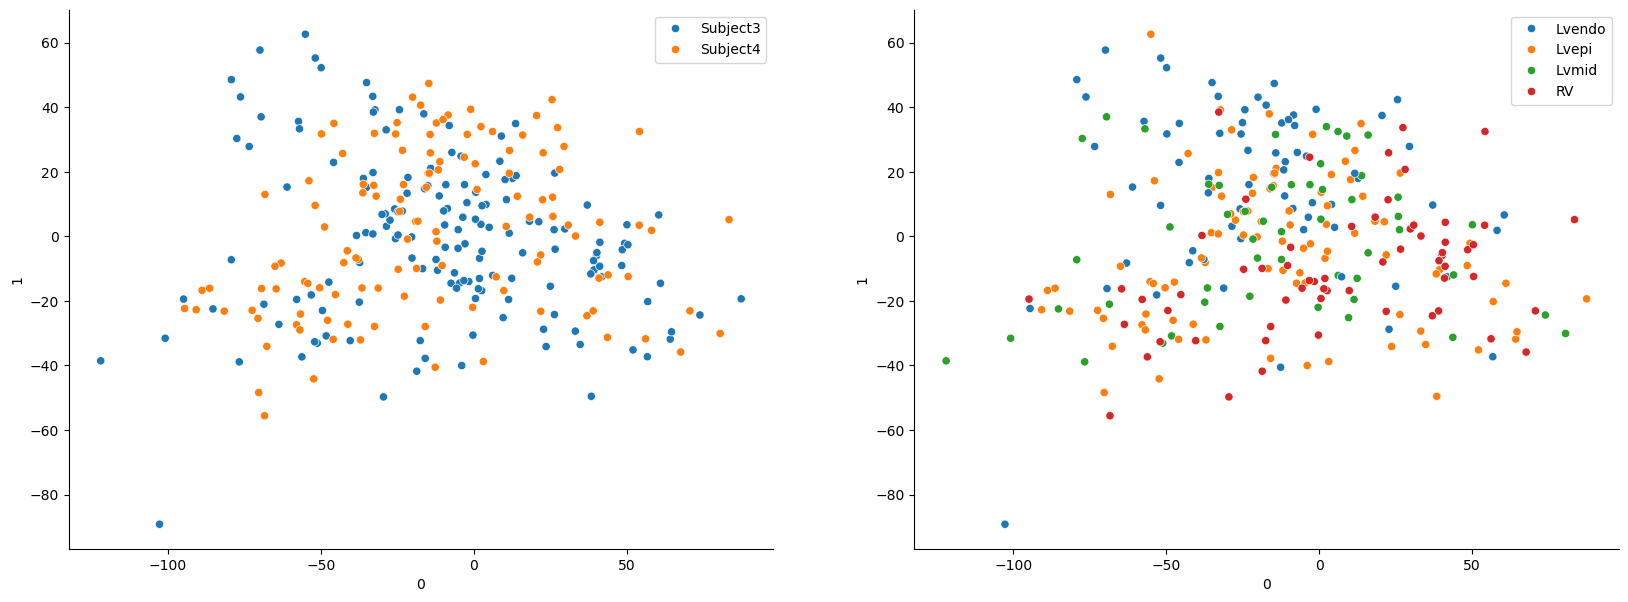

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,7))

sns.scatterplot(
    data=pd.DataFrame(ad.obsm['X_pca'][:, 0:2]),
    x=0,
    y=1,
    hue=ad.obs['Subject'].tolist(),
    ax=ax[0]
)
sns.scatterplot(
    data=pd.DataFrame(ad.obsm['X_pca'][:, 0:2]),
    x=0,
    y=1,
    hue=ad.obs['HeartLocation'].tolist(),
    ax=ax[1]
)

In [67]:
import palantir

In [68]:
dm_res = palantir.utils.run_diffusion_maps(
    ad, 
    n_components=10
)

In [70]:
ms_data = palantir.utils.determine_multiscale_space(ad)

In [71]:
# Calculate UMAP on the PC matrix
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [72]:
ad

AnnData object with n_obs × n_vars = 278 × 6564
    obs: 'File.Name', 'Sample', 'Date', 'Subject', 'PlateWell', 'Position', 'HeartLocation', 'runCol', 'MedianIntensity', 'TotalIds', 'MedianCV'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'Modified.Sequence', 'Stripped.Sequence', 'Precursor.Id', 'Precursor.Charge', 'Global.Q.Value', 'Global.PG.Q.Value', 'Translated.Q.Value', 'Proteotypic', 'iRT', 'First.Protein.Description', 'Lib.Q.Value', 'Lib.PG.Q.Value', 'iIM'
    uns: 'DM_EigenValues', 'neighbors', 'umap'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

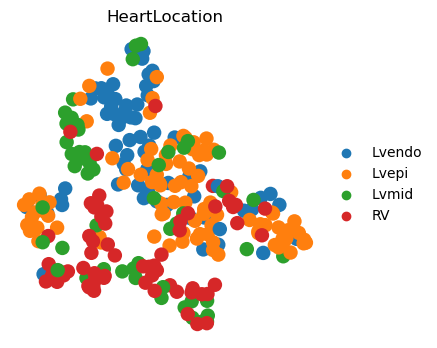

In [73]:
# Use scanpy functions to visualize umaps
sc.pl.embedding(
    ad,
    basis="X_umap",
    color='HeartLocation',
    frameon=False,
)

In [74]:
# Select the complete right part as the starting cell (normally you would select the undifferentiated cell)
selected_start_cell = pd.DataFrame(ad.obsm['X_umap']).sort_values(0).iloc[-1].name

In [75]:
# Select for illustrative purposes three terminal cells. Normally these would also be choosen based on annotations
umap = pd.DataFrame(ad.obsm['X_umap'])
terminal_states = [
    ad.obs.iloc[umap.sort_values(0).iloc[0].name]['File.Name'],
    ad.obs.iloc[umap.sort_values(1).iloc[0].name]['File.Name'],
    ad.obs.iloc[umap.sort_values(1).iloc[-1].name]['File.Name']    
]

In [76]:
terminal_states

['X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_LVepi_H20_BH21_1_7586.d',
 'X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_RV_A6_BA8_1_7459.d',
 'X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_Lvmid_B12_BB13_1_7464.d']

The diffusion components can be visualized on top of the UMAP dimensionality reduced data

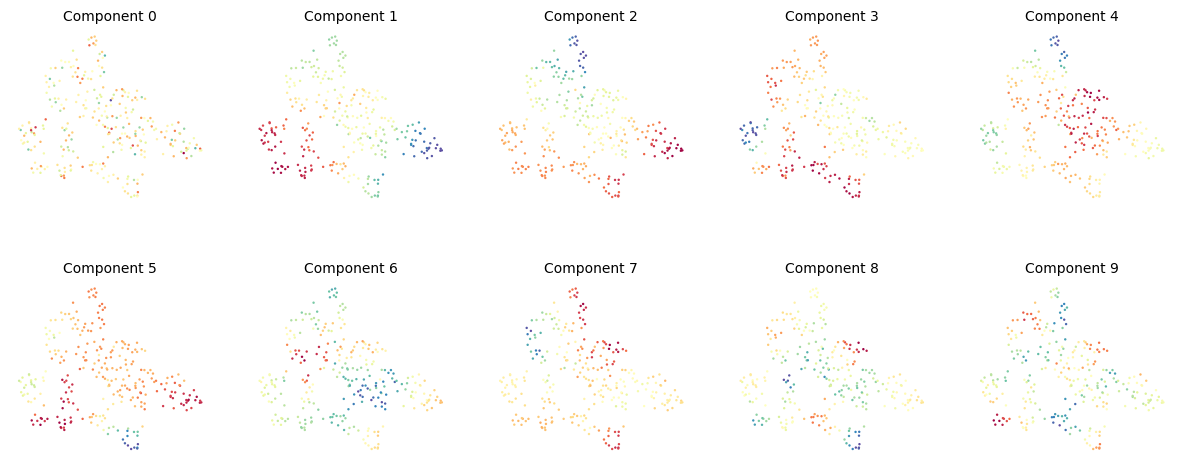

In [77]:
palantir.plot.plot_diffusion_components(ad)
plt.show()

Alternatively, a protein can also be visualized to see gradients. We could visualize TITIN (todo)

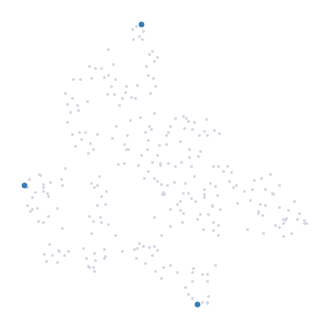

In [ ]:
# The chosen terminal cells are shown here

palantir.plot.highlight_cells_on_umap(
    ad,
    terminal_states
)
plt.show()

## Create a trajectory starting from some cell

In [ ]:
# Compute pseudotime
pr_res = palantir.core.run_palantir(
    ad,
    ad.obs.iloc[selected_start_cell]['File.Name'],
    num_waypoints=100,
    terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 6.759961446126303e-05 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Time for shortest paths: 0.18148767153422038 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9920
Correlation at iteration 2: 0.9995
Correlation at iteration 3: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


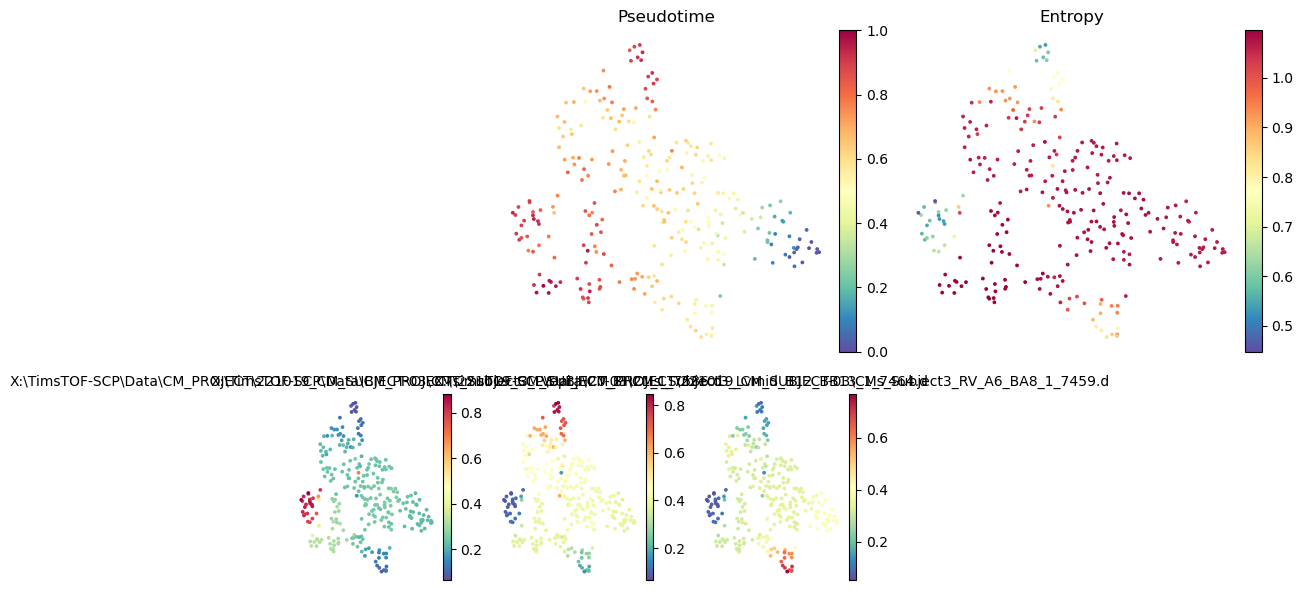

In [80]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

In [81]:
masks = palantir.presults.select_branch_cells(ad, q=.01, eps=.01)

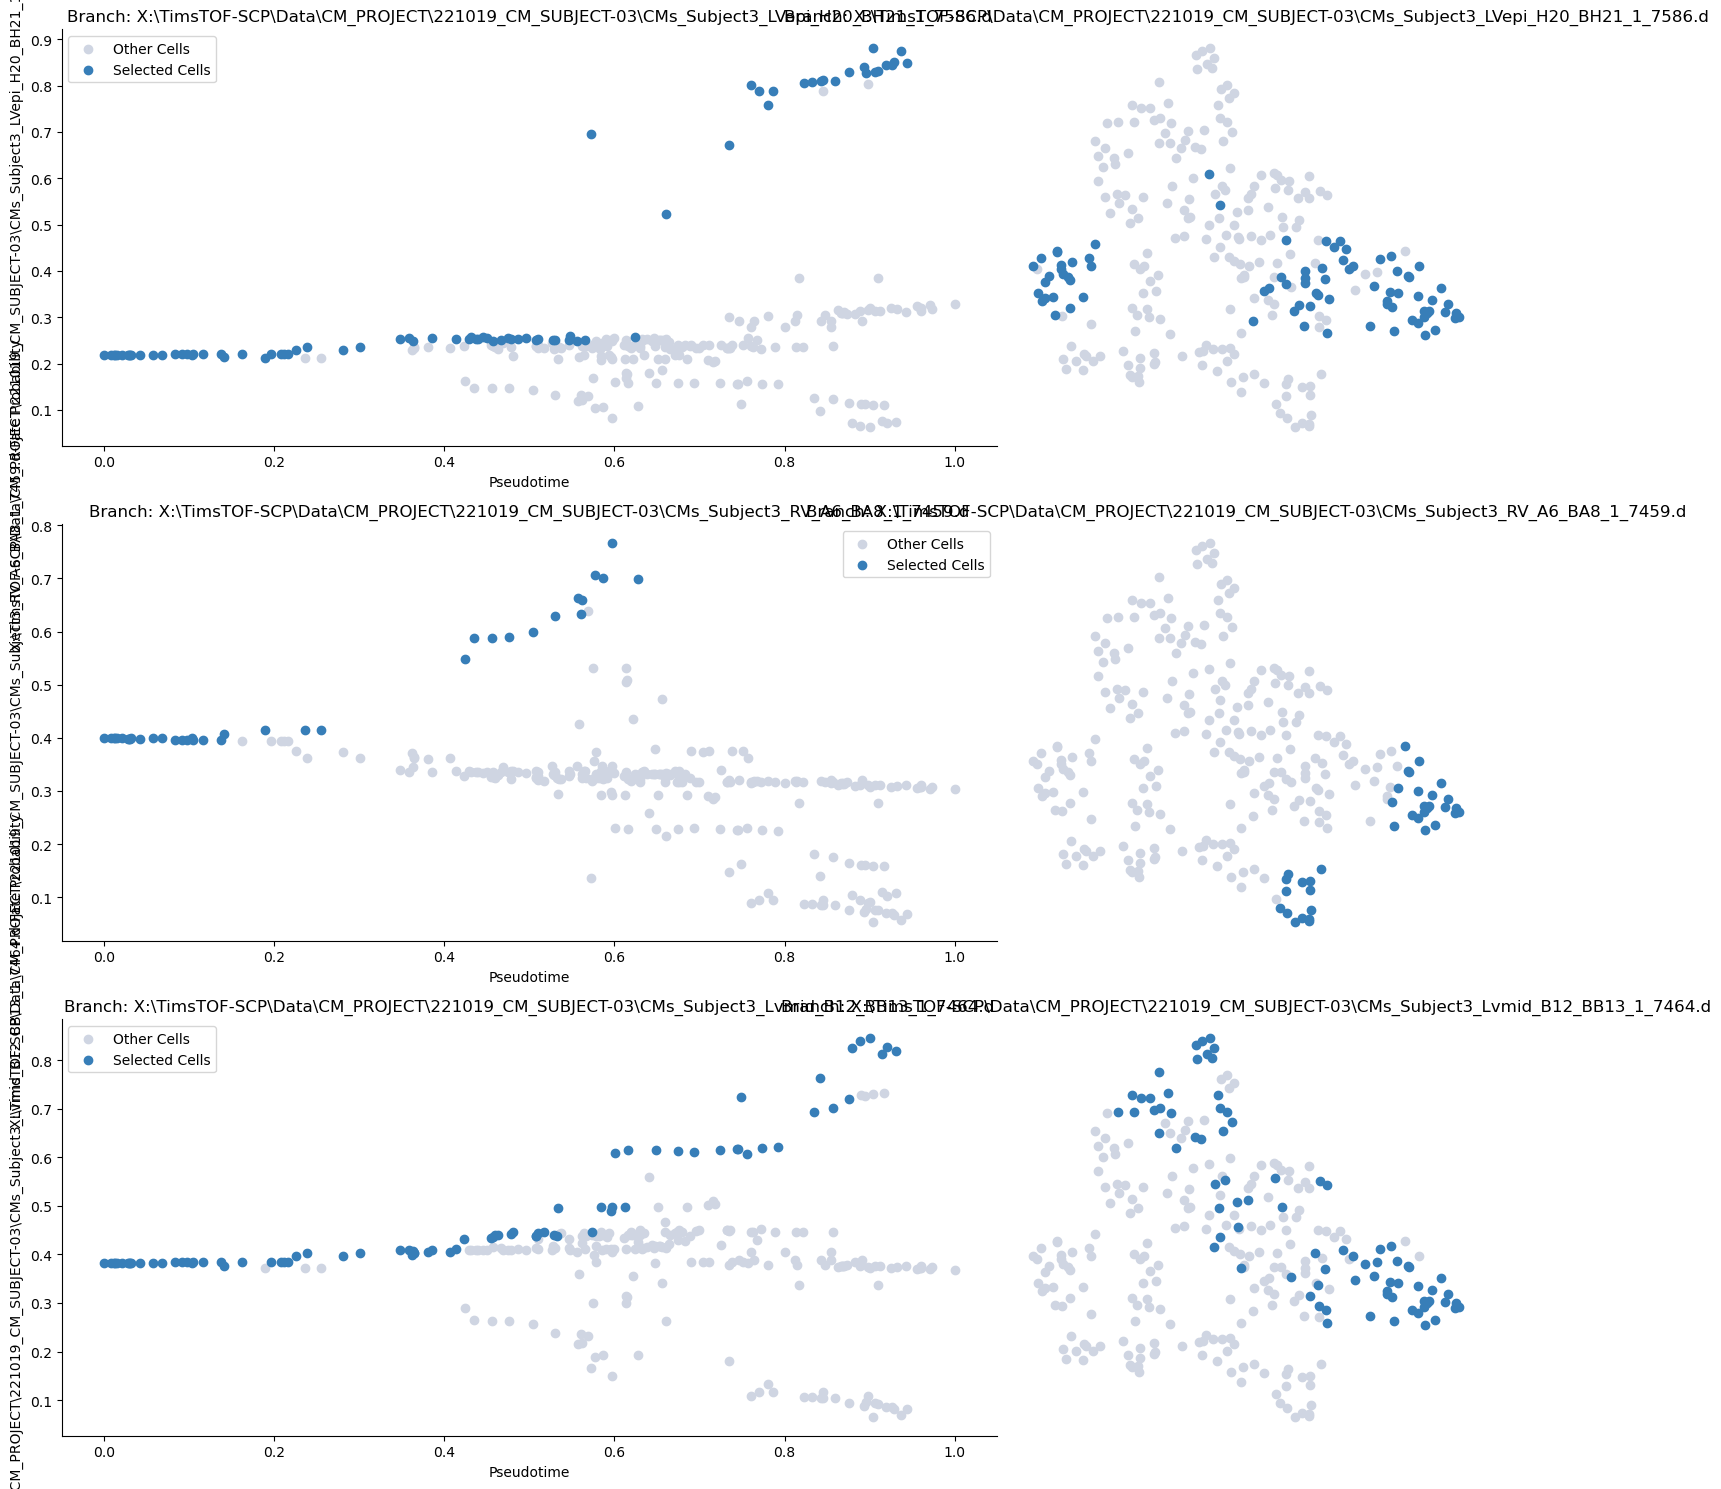

In [82]:
palantir.plot.plot_branch_selection(ad)
plt.show()

[2025-02-06 15:09:00,688] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (80) and rank = 1.0.
[2025-02-06 15:09:00,689] [INFO    ] Using covariance function Matern52(ls=0.7500086784362793).
[2025-02-06 15:09:00,690] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-02-06 15:09:00,714] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_LVepi_H20_BH21_1_7586.d'}>

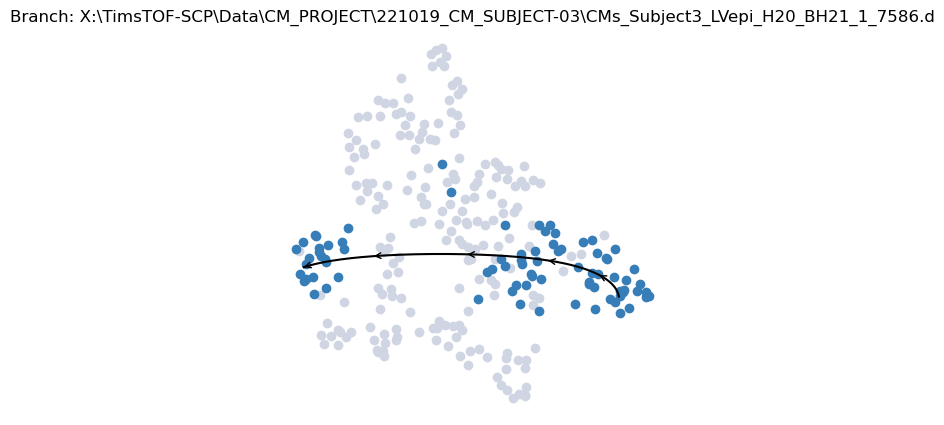

In [161]:
palantir.plot.plot_trajectory(ad,terminal_states[0])

[2025-02-06 14:21:58,581] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (81) and rank = 1.0.
[2025-02-06 14:21:58,582] [INFO    ] Using covariance function Matern52(ls=0.7500086784362793).
[2025-02-06 14:21:58,584] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-02-06 14:21:58,623] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_Lvmid_B12_BB13_1_7464.d'}, xlabel='UMAP1', ylabel='UMAP2'>

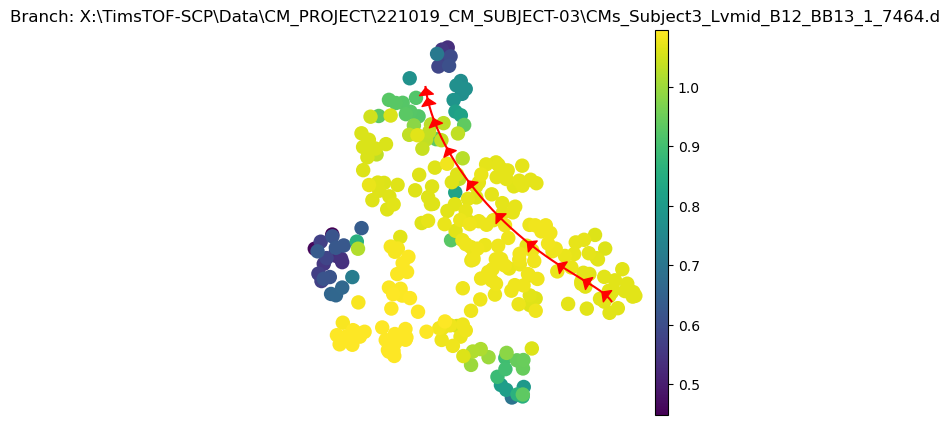

In [84]:
palantir.plot.plot_trajectory(
    ad,
    terminal_states[2],
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

Gene trends are calculated by using Mellon Function Estimator. Issue is that it cannot handle missing values, meaning, gene trends for only 13 precursors are calculated

In [86]:
gene_trends = palantir.presults.compute_gene_trends(
    ad
)

X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_H20_BH21_1_7586.d
[2025-02-06 14:22:48,661] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (80) and rank = 1.0.
[2025-02-06 14:22:48,662] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-02-06 14:22:49,395] [INFO    ] Sigma interpreted as element-wise standard deviation.
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_Lvmid_B12_BB13_1_7464.d
[2025-02-06 14:22:49,949] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (81) and rank = 1.0.
[2025-02-06 14:22:49,950] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-02-06 14:22:50,493] [INFO    ] Sigma interpreted as element-wise standard deviation.
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_RV_A6_BA8_1_7459.d
[2025-02-06 14:22:51,103] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (37) and rank = 1.0.
[2025-0

In [145]:
gene_trends = gene_trends['X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_LVepi_H20_BH21_1_7586.d']['trends']

In [150]:
(gene_trends.isna().sum(axis=1)==0).value_counts()

False    6551
True       13
Name: count, dtype: int64

In [154]:
genes_with_trends = gene_trends.loc[(gene_trends.isna().sum(axis=1)==0)].index

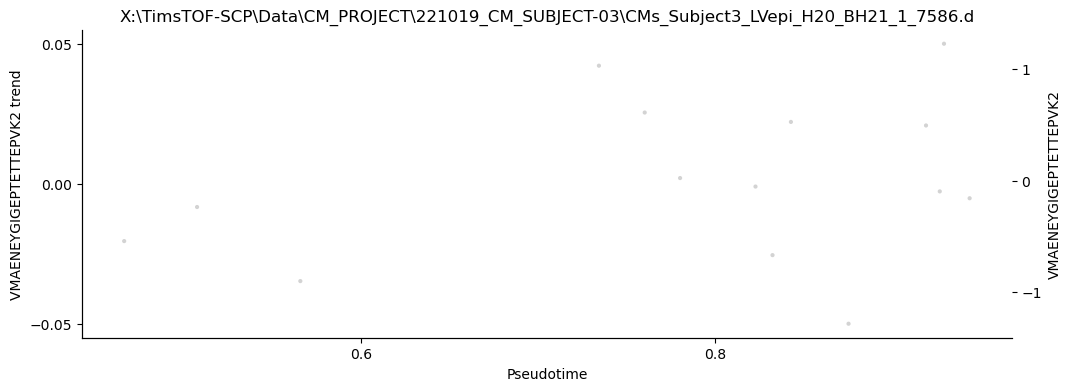

In [170]:
# You can plot a gene trend for a precursor with missing values. Here, one is plotted for a precursor coming from TITIN
palantir.plot.plot_trend(ad, terminal_states[0], "VMAENEYGIGEPTETTEPVK2")
plt.show()

For each defined gene trend, the expression profile along the inferred trajectories can be visualized.

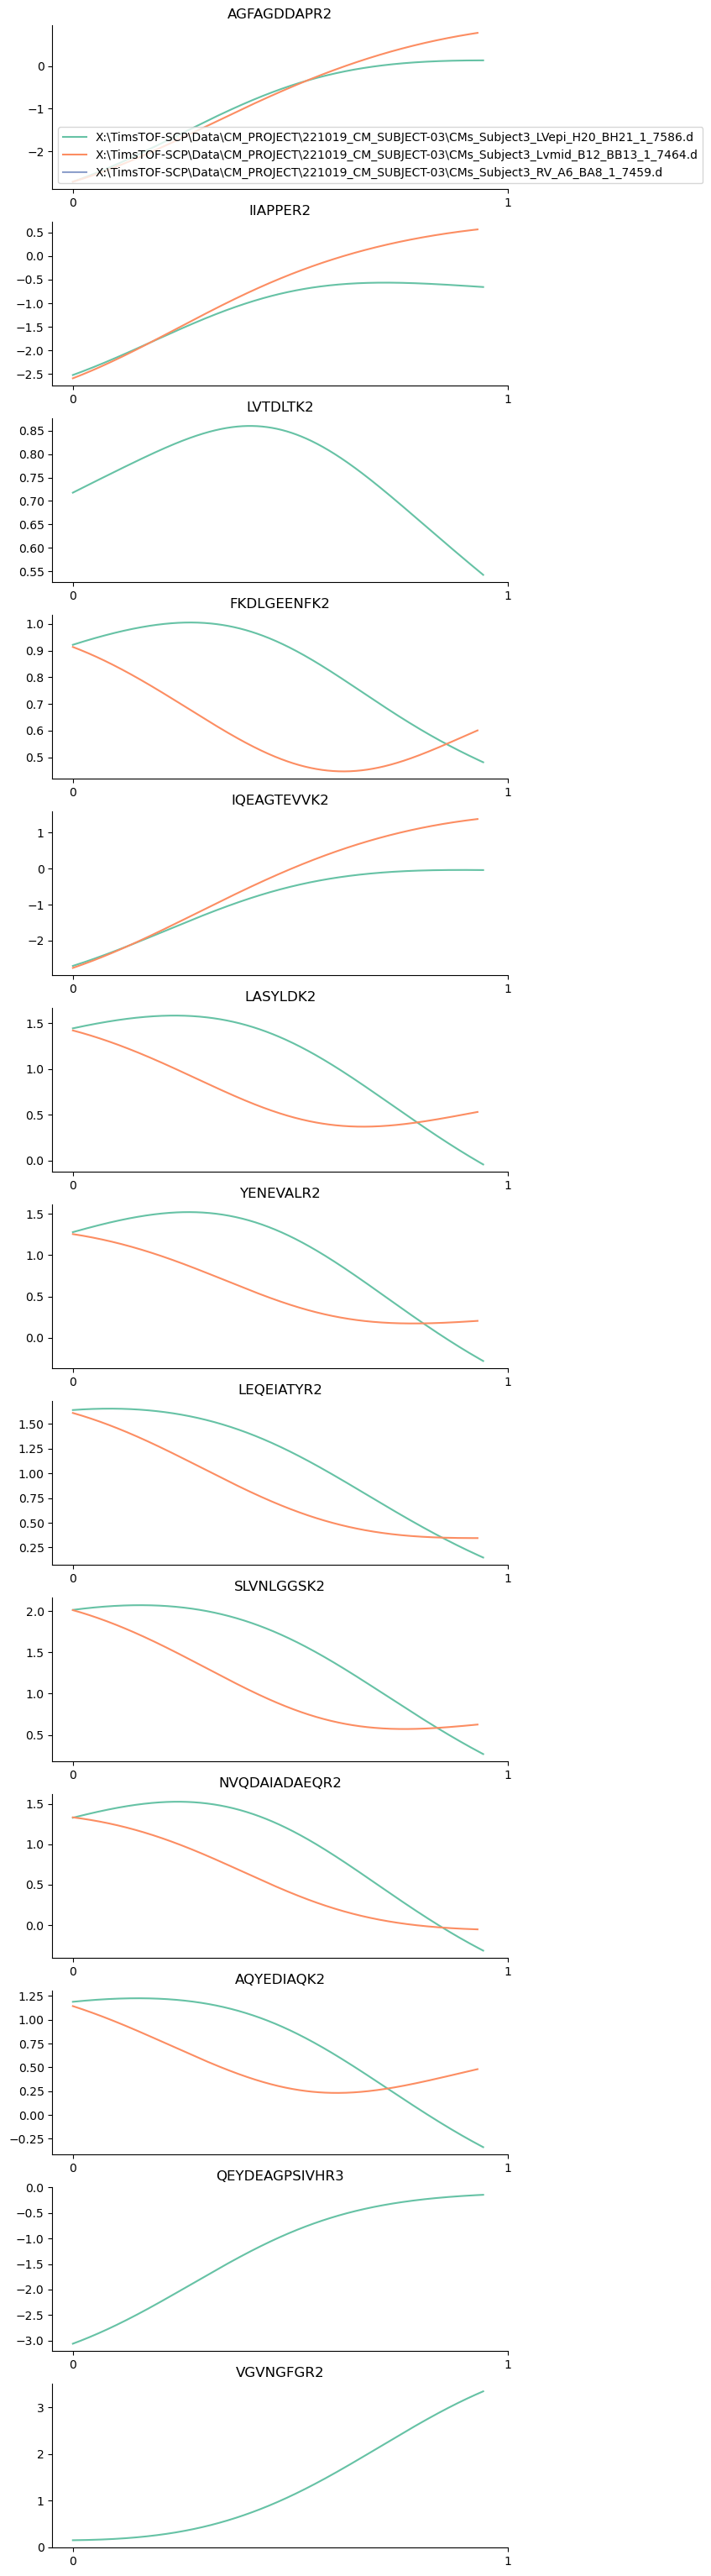

In [155]:
palantir.plot.plot_gene_trends(
    ad,
    genes_with_trends,
)
plt.legend().remove()
plt.show()

In [171]:
communities = palantir.presults.cluster_gene_trends(ad, terminal_states[0])

/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


ValueError: Input X contains NaN.
KNeighborsTransformer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values